<font color='green'> 
**Youtube - Aladdin Persson Kanalı - TensorFlow 2.0 Beginner Tutorials serisi**
    
TensorFlow Tutorial 17 - Complete TensorBoard Guide - Aladdin Persson anlattı.
</font>

**Video**: [TensorFlow Tutorial 17 - Complete TensorBoard Guide](https://www.youtube.com/watch?v=k7KfYXXrOj0&list=PLhhyoLH6IjfxVOdVC1P1L5z5azs0XjMsb&index=17)

### İçindekiler

**Loading, Preprocessing Dataset and Creating Model**

**1. Testboarda yazmak için train_writer ve test_writer tanımladık.**

**2. Custom training loop içerisinde tensorboard için kod yazıyoruz.**

**3. Custom testing loop içerisinde tensorboard için kod yazıyoruz.**

**4. Tensorboardı anaconda prompt aracılığıyla açıyoruz.**

**5. Hyperparameter search için de kullanıyoruz tensorboardı.**


## <font color="blue"> Create Tensorboard Using Custom Training Loop</font>

Custom training loop kullanarak nasıl yapıyoruz? Gösterilen her şeyi callbacks kullanarak veya model.fit() kullanarak yapabiliriz. 

### Loading, Preprocessing Dataset and Creating Model

In [1]:
import io
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    "cifar10",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete1PWM9R/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete1PWM9R/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255.0, label

In [4]:
def augment(image,label):
  if tf.random.uniform((), minval=0, maxval=1) < 0.1:
    image = tf.tile(tf.image.rgb_to_grayscale(image)), [1, 1, 3]

  image = tf.image.random_brightness(image, max_delta=0.1)
  image = tf.image.random_flip_left_right(image)

  return image, label

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(AUTOTUNE)

In [7]:
def get_model():
  model = keras.Sequential(
      [
       layers.Input((32, 32, 3)),
       layers.Conv2D(8, 3, padding="same", activation="relu"),
       layers.Conv2D(16, 3, padding="same", activation="relu"),
       layers.MaxPooling2D((2,2)),
       layers.Flatten(),
       layers.Dense(64, activation="relu"),
       layers.Dropout(0.1),
       layers.Dense(10),
      ]
  )
  return model

In [8]:
model = get_model()

In [9]:
num_epochs = 1 
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
acc_metric = keras.metrics.SparseCategoricalAccuracy()

### <font color="black"> 1. Testboarda yazmak için train_writer ve test_writer tanımladık.</font>

In [10]:
# train_writer ve test_writer'ı tensorboard'a yazmak için kullanacağız.
train_writer = tf.summary.create_file_writer("logs/train/")
test_writer = tf.summary.create_file_writer("logs/test/")

### <font color="black"> 2. Custom training loop içerisinde tensorboard için kod yazıyoruz.</font>

In [11]:
# Custom Training Loop
for epoch in range(num_epochs):
  print(f"\nStart of Training Epoch {epoch}")

  for batch_idx, (x_batch, y_batch) in enumerate (ds_train): 
    with tf.GradientTape() as tape:   
      y_pred = model(x_batch, training=True)
      loss = loss_fn(y_batch, y_pred) 
      
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    acc_metric.update_state(y_batch, y_pred) 
    # batch için buraya yazmamız gerekiyor

  # bu kısmı tensorboard için yazdık
  with train_writer.as_default():
    tf.summary.scalar("Loss", loss, step=epoch) 
    tf.summary.scalar("Accuracy", acc_metric.result(), step=epoch)

  train_acc = acc_metric.result()
  print(f"Accuracy over epoch {train_acc}")
  acc_metric.reset_states() # epochlar arasında accuracyi resetliyoruz


Start of Training Epoch 0
Accuracy over epoch 0.3604600131511688


* Her batchten sonra tensorboarda yazdırabilirsin ama her epochtan sonra yapmak daha mantıklı. 

* Lossu ve accuracyi göndereceğiz tensorflowa. Bunu epoch döngüsü içerisinde with ile başlayan kod ile yaptık. 

* `tf.summary.scalar("Loss", loss, step=epoch)` buradaki loss batchin son lossu olacak. Ama genelde lossun ortalamasını göndermek isteriz. Bunu yapmak için (batch döngüsü içinde bulunan) lossların listesini tutmamız ve onların ortalamasını almamız gerekecek. 

* Aynı şeyleri test set için de yazdık.


### <font color="black"> 3. Custom testing loop içerisinde tensorboard için kod yazıyoruz.</font>

In [13]:
# Custom Testing Loop
for batch_idx, (x,y) in enumerate(ds_test): 
  y_pred = model(x, training=False)
  acc_metric.update_state(y, y_pred)

# bu kısmı tensorboard için yazdık
with test_writer.as_default():
  tf.summary.scalar("Loss", loss, step=epoch) 
  tf.summary.scalar("Accuracy", acc_metric.result(), step=epoch)

test_acc = acc_metric.result()
print(f"Accuracy over Test Set: {test_acc}")

Accuracy over Test Set: 0.48829999566078186


Burada unutulmaması gereken şey biz farklı bir log directory kullanmadık. Train ve testi aynı logs klasörü içine koyduk. 

```
train_writer = tf.summary.create_file_writer("logs/train/")
test_writer = tf.summary.create_file_writer("logs/test/")
```


### <font color="black"> 4. Tensorboardı anaconda prompt aracılığıyla açıyoruz.</font>

Anaconda promptu açtığımızda bu sefer `tensorboard --logdir tb_callback_dir` yerine `tensorboard --logdir logs` yazıyoruz. Bu otomatik olarak trainingi ve testingi bulacak. 

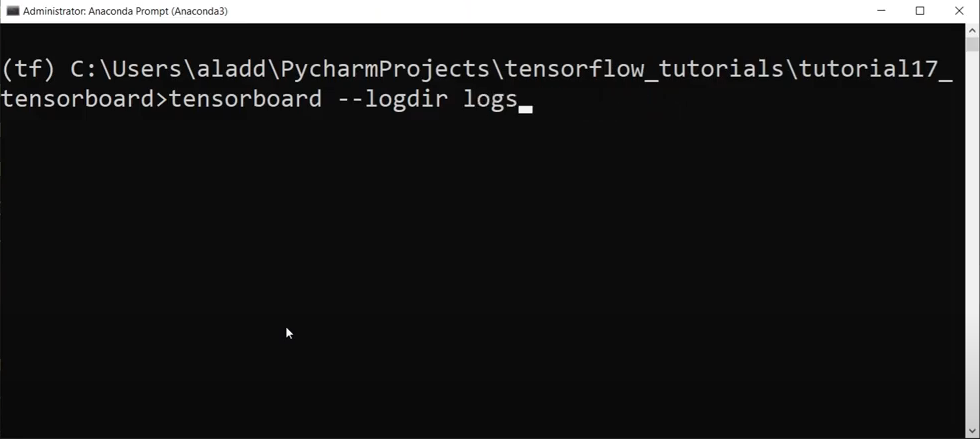

Bunu çalıştırdıktan sonra tarayıcımıza gittiğimizde localhost:6006'ya gidiyoruz. Biraz sürebiliyor çünkü tüm epochları yazıyor. Baktığımızda accuracy ve loss plotlarını görüyoruz. Bunlar çok açık ayrık adımlardan oluşuyor çünkü tüm epochları kaydediyoruz. Her batch için çalıştırsaydık daha smoother bir grafik elde ederdik. Accuracye baktığımızda yine validation accuracynin train accuracysinden fazla olduğunu görüyoruz, bunu train için yaptığımız data augmentationa bağladık. Mesela trainde bazı rgb resimleri grayscale yapmıştık dolayısıyla bu, eğitimi zorlaştırıyor.

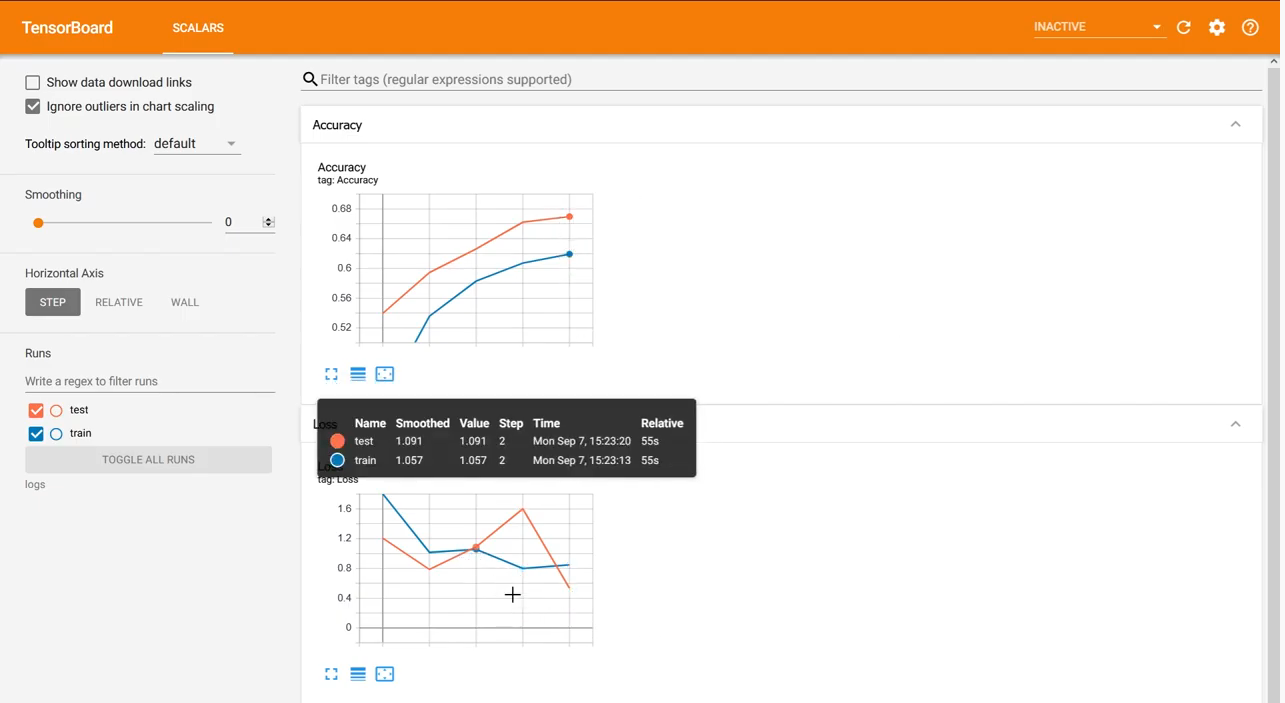

### 5. Hyperparameter search için de kullanıyoruz tensorboardı.

Her bir ilgili learning rate ile belirli sayıda epoch için bir model eğitebiliriz. Burada sadece bu beş farklı learning rate için grid search yapıyoruz.

In [15]:
# Custom Training Loop

for lr in [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
  train_step = test_step = 0
  train_writer = tf.summary.create_file_writer("logs/train"+str(lr)) # learning rate'i buraya ekledik.
  test_writer = tf.summary.create_file_writer("logs/test"+str(lr))

  # her seferinde weightleri resetleyeceğiz bu yüzden modeli tanımladık burada.
  model = get_model()
  optimizer = keras.optimizers.Adam(learning_rate=lr)

  
  for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    for batch_idx, (x_batch, y_batch) in enumerate (ds_train): 
      with tf.GradientTape() as tape:   
        y_pred = model(x_batch, training=True)
        loss = loss_fn(y_batch, y_pred) 
        
      gradients = tape.gradient(loss, model.trainable_weights)
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))
      acc_metric.update_state(y_batch, y_pred) 
      # batch için buraya yazmamız gerekiyor

    # Her batch için yapacağımız için bu kodu içeri aldık. Daha smoother bir grafik olacak.
      with train_writer.as_default():
        tf.summary.scalar("Loss", loss, step=train_step) # buradaki loss batchin son lossu olacak.
        tf.summary.scalar("Accuracy", acc_metric.result(), step=train_step) 
        train_step += 1

    train_acc = acc_metric.result()
    print(f"Accuracy over epoch {train_acc}")
    acc_metric.reset_states() # epochlar arasında accuracyi resetliyoruz


Start of Training Epoch 0
Accuracy over epoch 0.2117714285850525

Start of Training Epoch 0
Accuracy over epoch 0.2890999913215637

Start of Training Epoch 0
Accuracy over epoch 0.37887999415397644

Start of Training Epoch 0
Accuracy over epoch 0.2787199914455414

Start of Training Epoch 0
Accuracy over epoch 0.18000000715255737


`tf.summary.scalar("Accuracy", acc_metric.result(), step=epoch)`daki `step=epoch` yerine `step=train_step` yazdık. train_stepi her seferinde artıracağız.

In [17]:
# Custom Testing Loop
for batch_idx, (x,y) in enumerate(ds_test): 
  y_pred = model(x, training=False)
  acc_metric.update_state(y, y_pred)

  # bu kısmı tensorboard için yazdık
  with test_writer.as_default():
    tf.summary.scalar("Loss", loss, step=test_step) 
    tf.summary.scalar("Accuracy", acc_metric.result(), step=test_step) # test_step yazdık epoch yerine
    test_step+=1

test_acc = acc_metric.result()
print(f"Accuracy over Test Set: {test_acc}")

Accuracy over Test Set: 0.2578001618385315


Tensorboarda baktığımızda sadece trainin sonucunu görüyoruz farklı learning rate'lere göre.

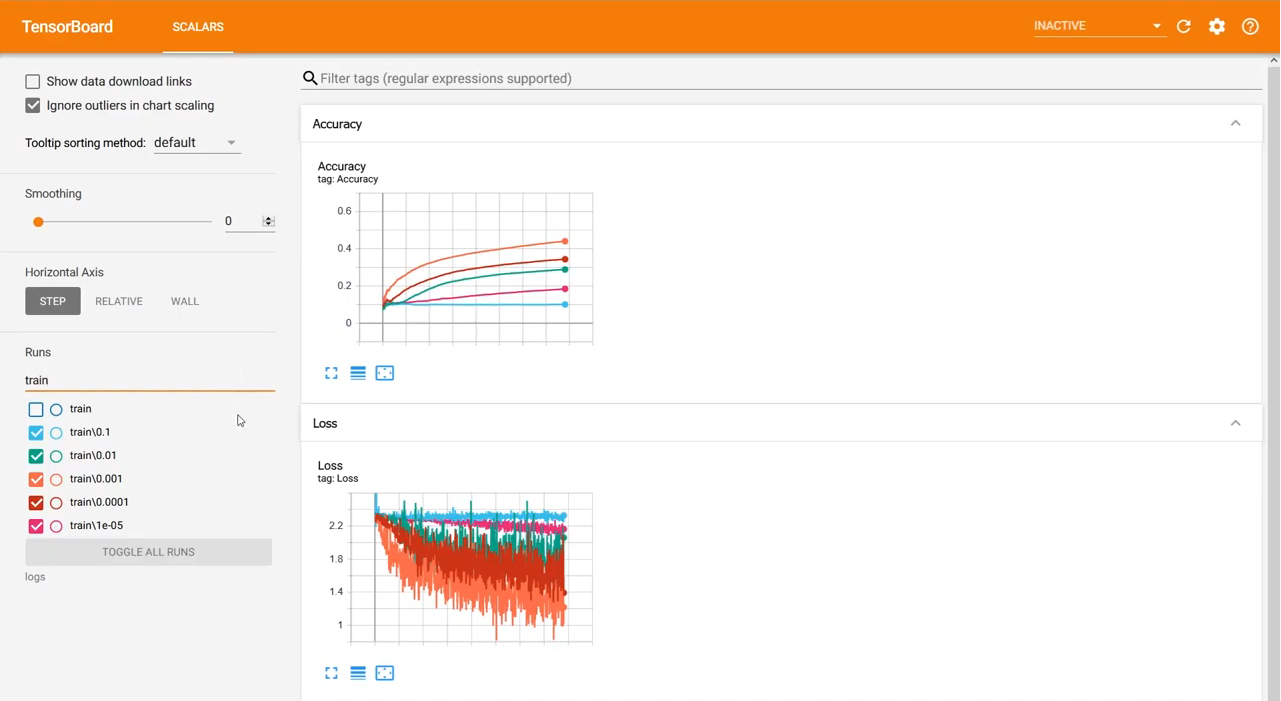

Smoothing üzerinde oynayarak farklı batchlerde farklı görünüm elde edebiliyoruz. 

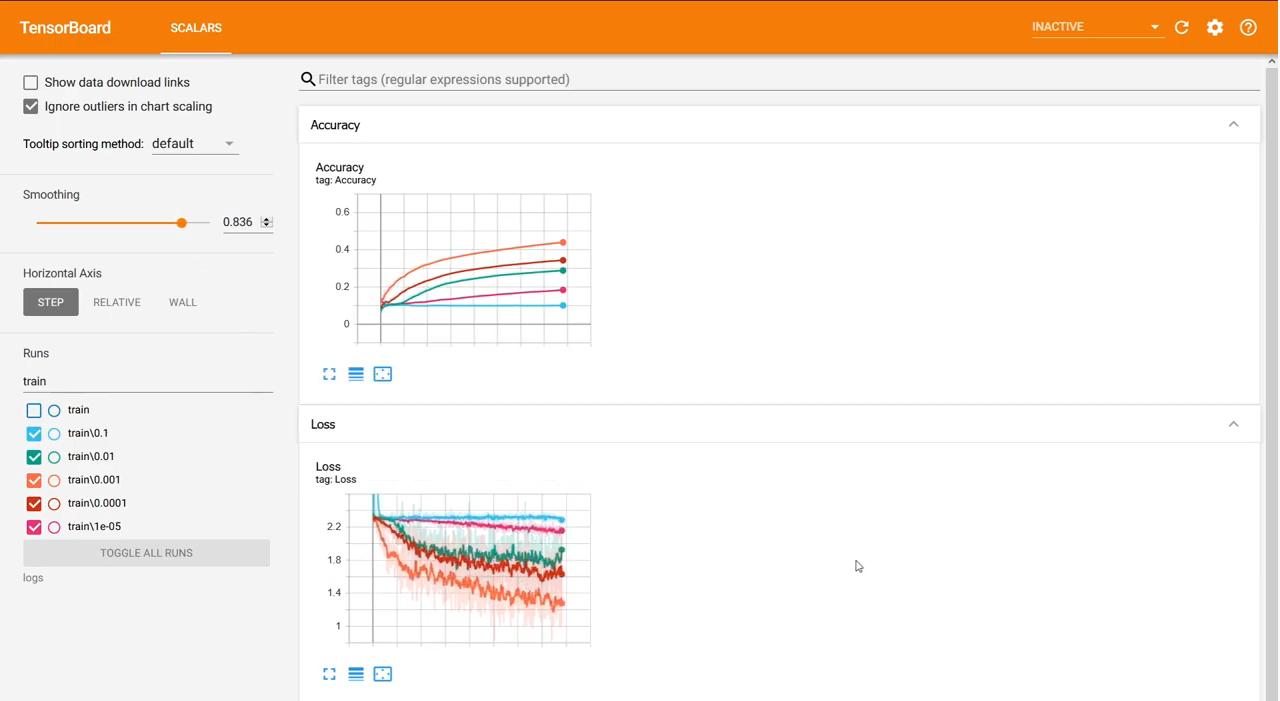

Accuracy'e baktığımızda initial learning rate'in muhtemelen 0.001 ve 0.0001 arasında olması gerektiğini anlayabiliyoruz.

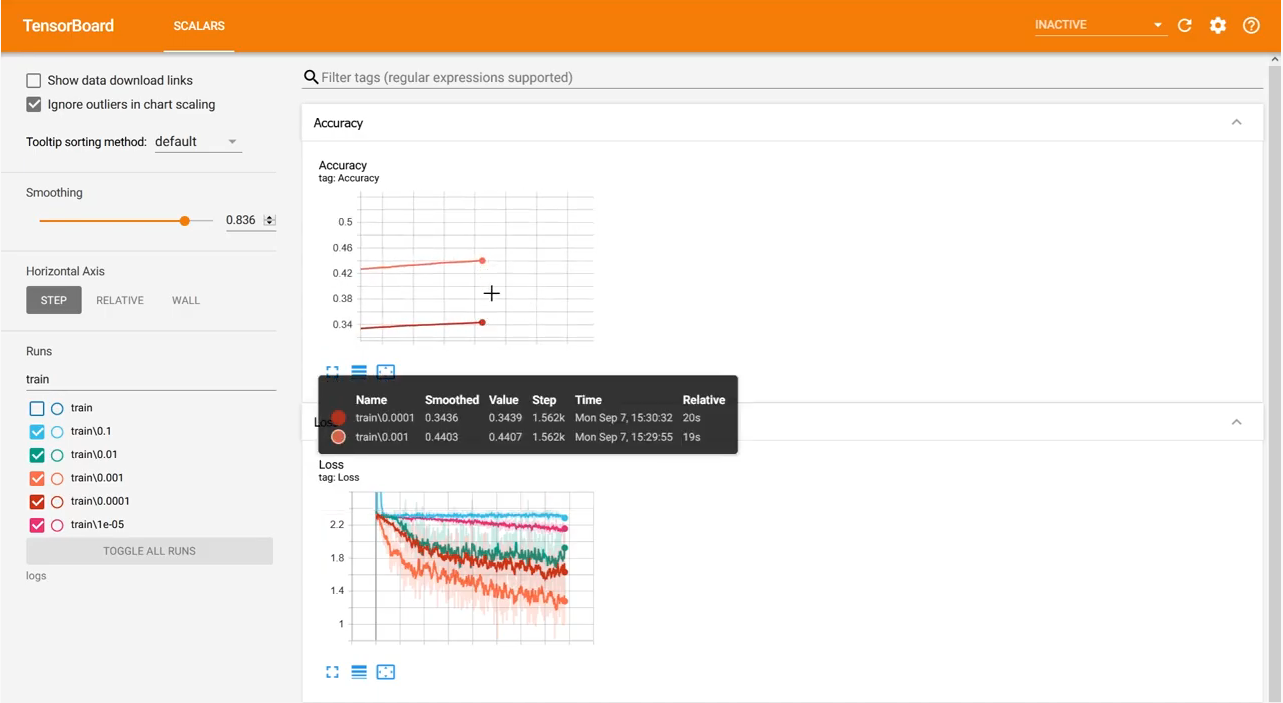